In [1]:
import os
import cv2
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


In [2]:
PROGRAM_PATH = os.path.abspath("..")
if PROGRAM_PATH not in sys.path:
    sys.path.append(PROGRAM_PATH)

In [3]:
from Helpers.GeneralHelpers import *
from Helpers.RHDHelpers import *
from DataHandling.PreProcessing import *
from Model.PoolingAndFire import create_loss_function

In [4]:
#MODEL_FILE = os.path.expanduser("~/results/SqueezeDet/all_points.h5py")
#MODEL_FILE = os.path.expanduser("~/results/SqueezeDet/all_points_complete_run_09.h5py")
MODEL_FILE = os.path.expanduser("~/results/SVPGestureRec/all_points_overfit_32.h5py")
RHD_ANNOTATIONS_FILE = os.path.expanduser("~/datasets/RHD/RHD_published_v2/training/anno_training.pickle")
VALIDATION_DIR = os.path.expanduser("~/datasets/RHD/processed/validation")
TRAIN_DIR = os.path.expanduser("~/datasets/RHD/processed/train")
VALIDATION_ANNOTATIONS = os.path.expanduser("~/datasets/RHD/processed/validation/annotations/")
TRAIN_ANNOTATIONS = os.path.expanduser("~/datasets/RHD/processed/train/annotations/")

In [5]:
create_rhd_annotations(RHD_ANNOTATIONS_FILE,
                       VALIDATION_ANNOTATIONS,
                       VALIDATION_DIR,
                       fingers='ALL',
                       hands_to_annotate='BOTH',
                       annotate_non_visible=False,
                       force_new_files=True)

 12%|█▏        | 493/4126 [00:00<00:00, 4916.90it/s]

Creating annotations in directory: /home/clh/datasets/RHD/processed/validation
Using annotation file: /home/clh/datasets/RHD/RHD_published_v2/training/anno_training.pickle
And outputting to: /home/clh/datasets/RHD/processed/validation/annotations/


100%|██████████| 4126/4126 [00:00<00:00, 5115.69it/s]


In [6]:
BATCHSIZE = 64
EPSILON = 1e-16

LABEL_WEIGHT = 1.0
OFFSET_LOSS_WEIGHT = 1.0
OFFSET_SCALE = int(320 / 20)

NUM_CLASSES = 42

l = create_loss_function(20,
                         20,
                         LABEL_WEIGHT,
                         OFFSET_SCALE,
                         OFFSET_LOSS_WEIGHT,
                         NUM_CLASSES,
                         EPSILON,
                         BATCHSIZE)

In [7]:
model = load_model(MODEL_FILE, custom_objects={'loss_function': l})

In [8]:
samples_dir = VALIDATION_DIR
annotations_dir = VALIDATION_ANNOTATIONS
NUM_SAMPLES_TO_CHECK = 10

In [9]:
samples_to_check = []
for fi in os.listdir(samples_dir):
    if fi.endswith('png'):
        samples_to_check.append(int(fi.split('.')[0]))
        if len(samples_to_check) >= NUM_SAMPLES_TO_CHECK:
            break

print(samples_to_check)

[39255, 37303, 37656, 37244, 40921, 37184, 39166, 38639, 37728, 38312]


In [10]:
labels, images = load_data_with_anchors(samples_to_check,
                                        samples_dir,
                                        annotations_dir,
                                        320, 320,
                                        20, 20,
                                        OFFSET_SCALE,
                                        'png',
                                        num_classes=NUM_CLASSES,
                                        greyscale=True)

images_show = np.zeros((len(images), 320, 320, 3), dtype=np.uint8)
for c, im in enumerate(images):
    #images_show[c] = cv2.cvtColor((im * 255.0).astype(np.uint8), cv2.COLOR_BGR2RGB)
    images_show[c][:, :, 0] = im.reshape(320, 320) * 255.0
    images_show[c][:, :, 1] = im.reshape(320, 320) * 255.0
    images_show[c][:, :, 2] = im.reshape(320, 320) * 255.0

print(np.max(images[0]))

0.5607843137254902


In [11]:
for l in labels:
    print(l.shape)
    for i in range(NUM_CLASSES):
        offset_xs = l[:, :, NUM_CLASSES+i*2]
        offset_ys = l[:, :, NUM_CLASSES+1+i*2]
        
        print(f"Offset max x: {np.max(offset_xs)}")
        print(f"Offset max y: {np.max(offset_ys)}")
        print("")

(20, 20, 126)
Offset max x: 0.30625009536743164
Offset max y: 0.7062501907348633

Offset max x: 0.65625
Offset max y: 0.17500019073486328

Offset max x: 0.875
Offset max y: 0.40625

Offset max x: 0.2687501907348633
Offset max y: 0.53125

Offset max x: 0.8312501907348633
Offset max y: 0.6000003814697266

Offset max x: 0.888124942779541
Offset max y: 0.5187501907348633

Offset max x: 0.03249979019165039
Offset max y: 0.5625

Offset max x: 0.08437490463256836
Offset max y: 0.5249996185302734

Offset max x: 0.2775001525878906
Offset max y: 0.8812503814697266

Offset max x: 0.9262499809265137
Offset max y: 0.11874961853027344

Offset max x: 0.11562490463256836
Offset max y: 0.8812503814697266

Offset max x: 0.31687498092651367
Offset max y: 0.7749996185302734

Offset max x: 0.6418747901916504
Offset max y: 0.01875019073486328

Offset max x: 0.07062482833862305
Offset max y: 0.18124961853027344

Offset max x: 0.7881250381469727
Offset max y: 0.3125

Offset max x: 0.39874982833862305
Offset m

In [12]:
right_hand = []
left_hand = []

with open(RHD_ANNOTATIONS_FILE, 'rb') as f:
    annotations = pickle.load(f)
    
for s in samples_to_check:
    right_hand.append(get_right_hand(s, annotations))
    left_hand.append(get_left_hand(s, annotations))

In [13]:
res = np.zeros(labels.shape)
process_times = []
for c, im in enumerate(images):
    before = time.time()
    #res.append(model.predict(im.reshape(1, 320, 320, 1)))
    res[c] = model.predict(im.reshape(1, 320, 320, 1))
    process_times.append(time.time() - before)
    
process_times = np.array(process_times)
print(f"Average processing time: {np.mean(process_times)}")
print(f"Max processing time: {np.max(process_times)}")
print(f"Min processing time: {np.min(process_times)}")
print(f"Average processing time excepting first: {np.mean(process_times[1:])}")

Average processing time: 0.1641378879547119
Max processing time: 1.4949610233306885
Min processing time: 0.01604604721069336
Average processing time excepting first: 0.01626865069071452


In [14]:
for c, l in enumerate(labels):
    for i in range(NUM_CLASSES):
        single_label = np.zeros((20, 20, 3))
        single_label[:, :, 0] = labels[c, :, :, i]
        single_label[:, :, 1] = labels[c, :, :, NUM_CLASSES+i*2]
        single_label[:, :, 2] = labels[c, :, :, NUM_CLASSES+1+i*2]
        
        anchors = get_anchors(320, 320, 20, 20)

        label_points = get_all_points_from_prediction(single_label,
                                                      anchors,
                                                      threshold=1.0,
                                                      offset_weight=OFFSET_SCALE)
        
        for p in label_points:
            x = p[0] + p[2]
            y = p[1] + p[3]
            
            #print(f"Label point: ({x}, {y})")
            #print(f"\tOffset: ({p[2]}, {p[3]})")
            print(f"point: ({x:.2f}, {y:.2f}), anchor point: ({p[0]:.2f}, {p[1]:.2f}), offset: ({p[2]:.2f}, {p[3]:.2f})")

            cv2.circle(images_show[c], (int(x), int(y)), 1, (0, 255, 0), thickness=2)
        print("")

point: (95.90, 178.30), anchor point: (91.00, 167.00), offset: (4.90, 11.30)
point: (95.90, 178.30), anchor point: (91.00, 182.00), offset: (4.90, -3.70)
point: (95.90, 178.30), anchor point: (106.00, 167.00), offset: (-10.10, 11.30)
point: (95.90, 178.30), anchor point: (106.00, 182.00), offset: (-10.10, -3.70)

point: (101.50, 169.80), anchor point: (91.00, 167.00), offset: (10.50, 2.80)
point: (101.50, 169.80), anchor point: (106.00, 167.00), offset: (-4.50, 2.80)
point: (101.50, 169.80), anchor point: (106.00, 182.00), offset: (-4.50, -12.20)

point: (105.00, 173.50), anchor point: (91.00, 167.00), offset: (14.00, 6.50)
point: (105.00, 173.50), anchor point: (106.00, 167.00), offset: (-1.00, 6.50)
point: (105.00, 173.50), anchor point: (106.00, 182.00), offset: (-1.00, -8.50)

point: (110.30, 175.50), anchor point: (106.00, 167.00), offset: (4.30, 8.50)
point: (110.30, 175.50), anchor point: (106.00, 182.00), offset: (4.30, -6.50)
point: (110.30, 175.50), anchor point: (121.00, 167

point: (204.40, 194.90), anchor point: (198.00, 198.00), offset: (6.40, -3.10)
point: (204.40, 194.90), anchor point: (213.00, 182.00), offset: (-8.60, 12.90)
point: (204.40, 194.90), anchor point: (213.00, 198.00), offset: (-8.60, -3.10)

point: (209.20, 180.40), anchor point: (198.00, 182.00), offset: (11.20, -1.60)
point: (209.20, 180.40), anchor point: (213.00, 167.00), offset: (-3.80, 13.40)
point: (209.20, 180.40), anchor point: (213.00, 182.00), offset: (-3.80, -1.60)

point: (213.60, 167.40), anchor point: (198.00, 167.00), offset: (15.60, 0.40)
point: (213.60, 167.40), anchor point: (213.00, 152.00), offset: (0.60, 15.40)
point: (213.60, 167.40), anchor point: (213.00, 167.00), offset: (0.60, 0.40)
point: (213.60, 167.40), anchor point: (213.00, 182.00), offset: (0.60, -14.60)
point: (213.60, 167.40), anchor point: (228.00, 167.00), offset: (-14.40, 0.40)

point: (220.40, 151.90), anchor point: (213.00, 152.00), offset: (7.40, -0.10)
point: (220.40, 151.90), anchor point: (228

point: (267.50, 182.10), anchor point: (274.00, 182.00), offset: (-6.50, 0.10)

point: (262.60, 193.50), anchor point: (259.00, 182.00), offset: (3.60, 11.50)
point: (262.60, 193.50), anchor point: (259.00, 198.00), offset: (3.60, -4.50)
point: (262.60, 193.50), anchor point: (274.00, 198.00), offset: (-11.40, -4.50)

point: (262.00, 200.50), anchor point: (259.00, 198.00), offset: (3.00, 2.50)
point: (262.00, 200.50), anchor point: (259.00, 213.00), offset: (3.00, -12.50)
point: (262.00, 200.50), anchor point: (274.00, 198.00), offset: (-12.00, 2.50)

point: (265.40, 201.40), anchor point: (259.00, 198.00), offset: (6.40, 3.40)
point: (265.40, 201.40), anchor point: (259.00, 213.00), offset: (6.40, -11.60)
point: (265.40, 201.40), anchor point: (274.00, 198.00), offset: (-8.60, 3.40)
point: (265.40, 201.40), anchor point: (274.00, 213.00), offset: (-8.60, -11.60)

point: (276.10, 185.90), anchor point: (274.00, 182.00), offset: (2.10, 3.90)
point: (276.10, 185.90), anchor point: (274.

In [15]:
THRESHOLD = 0.9

for c, r in enumerate(res):
    #print(r.shape)
    #pred = r.reshape(20, 20, 3)
    
    for i in range(NUM_CLASSES):
        pred = np.zeros((20, 20, 3))
        
        pred[:, :, 0] = res[c, :, :, i]
        pred[:, :, 1] = res[c, :, :, NUM_CLASSES+i*2]
        pred[:, :, 2] = res[c, :, :, NUM_CLASSES+1+i*2]
        
        #print(np.max(pred[:, :, 0]))
        
        anchors = get_anchors(320, 320, 20, 20)
        max_val = np.max(pred[:,:,0])
        #max_val = 0.9
        pred_point = get_all_points_from_prediction(pred,
                                                    anchors,
                                                    threshold=max_val,
                                                    offset_weight=OFFSET_SCALE,
                                                    is_label=False)
        
        for p in pred_point:
            x = p[0] + p[2]
            y = p[1] + p[3]
            
            print(f"Predicted point: ({x}, {y}), confidence: {max_val}")

            cv2.circle(images_show[c], (int(x), int(y)), 1, (255, 0, 0), thickness=1)

Predicted point: (63.285865783691406, 243.9944508075714), confidence: 0.18432262539863586
Predicted point: (184.8783061504364, 221.53938102722168), confidence: 0.021727146580815315
Predicted point: (75.80000877380371, 218.20088005065918), confidence: 0.15341192483901978
Predicted point: (68.28736305236816, 212.05335638299584), confidence: 0.31946393847465515
Predicted point: (44.19257527589798, 227.0064873690717), confidence: 0.9878358244895935
Predicted point: (90.5784912109375, 213.11356389522552), confidence: 0.007189770229160786
Predicted point: (88.2146053314209, 213.04666483402252), confidence: 0.38284197449684143
Predicted point: (55.638413429260254, 219.05999326705933), confidence: 0.2720862329006195
Predicted point: (46.11417031288147, 212.68296748399734), confidence: 0.3275148570537567
Predicted point: (75.57438278198242, 256.09559631347656), confidence: 0.7447426915168762
Predicted point: (85.56025886535645, 239.44922256469727), confidence: 0.09309852123260498
Predicted poin

Predicted point: (185.91224026679993, 75.43722534179688), confidence: 0.0021285221446305513
Predicted point: (215.33699560165405, 258.4287686049938), confidence: 0.022878121584653854
Predicted point: (254.06405067443848, 31.99397349357605), confidence: 0.0022967641707509756
Predicted point: (16.852078437805176, 151.24745009839535), confidence: 0.08647468686103821
Predicted point: (52.879191398620605, 116.44240379333496), confidence: 0.002433718414977193
Predicted point: (55.13112735748291, 109.9044361114502), confidence: 0.0059703318402171135
Predicted point: (202.97284984588623, 179.02660751342773), confidence: 0.005905086640268564
Predicted point: (198.2326946258545, 146.64722061157227), confidence: 0.002271014265716076
Predicted point: (32.047895431518555, 225.53306770324707), confidence: 0.0032980539835989475
Predicted point: (59.072397232055664, 182.4088840484619), confidence: 0.0017298992024734616
Predicted point: (199.24359512329102, 58.544169425964355), confidence: 0.0100298970

In [16]:
def confidence_score(label, prediction, num_classes):
    """
    How often does the model tag the correct anchor.
    """
    error = 0
    for i in range(num_classes):
        l = label[:, :, i]
        p = prediction[:, :, i]
        
        label_x, label_y = np.where(l==1.0)
        try:
            label_point = np.array([label_x[0], label_y[0]])
            print(f"label_point: {label_point}")
        except:
            print("Error")
            continue

        prediction_x, prediction_y = np.where(p==np.max(p))
        prediction_point = np.array([prediction_x[0], prediction_y[0]])
        
        print(f"prediction_point: {prediction_point}")
        
        label_error = np.linalg.norm(label_point - prediction_point)
        error += label_error
        print(label_error)
        
        print("")
    
    return error

#print(res.shape)
confidence_score(labels[0], res[0], 42)

label_point: [ 5 10]
prediction_point: [ 3 16]
6.324555320336759

label_point: [ 5 10]
prediction_point: [12 13]
7.615773105863909

label_point: [ 5 10]
prediction_point: [ 3 13]
3.605551275463989

label_point: [ 6 10]
prediction_point: [ 3 14]
5.0

label_point: [ 5 11]
prediction_point: [ 3 15]
4.47213595499958

label_point: [ 4 10]
prediction_point: [ 4 14]
4.0

label_point: [5 9]
prediction_point: [ 4 14]
5.0990195135927845

label_point: [5 9]
prediction_point: [ 3 14]
5.385164807134504

label_point: [5 9]
prediction_point: [ 3 14]
5.385164807134504

label_point: [ 3 10]
prediction_point: [ 3 15]
5.0

label_point: [4 9]
prediction_point: [ 4 15]
6.0

label_point: [4 9]
prediction_point: [ 3 15]
6.082762530298219

label_point: [ 4 10]
prediction_point: [ 3 15]
5.0990195135927845

label_point: [ 5 11]
prediction_point: [ 3 15]
4.47213595499958

label_point: [ 4 11]
prediction_point: [ 3 15]
4.123105625617661

label_point: [ 4 10]
prediction_point: [ 3 15]
5.0990195135927845

label_poi

236.1809781572895

In [17]:
def accuracy():
    pass

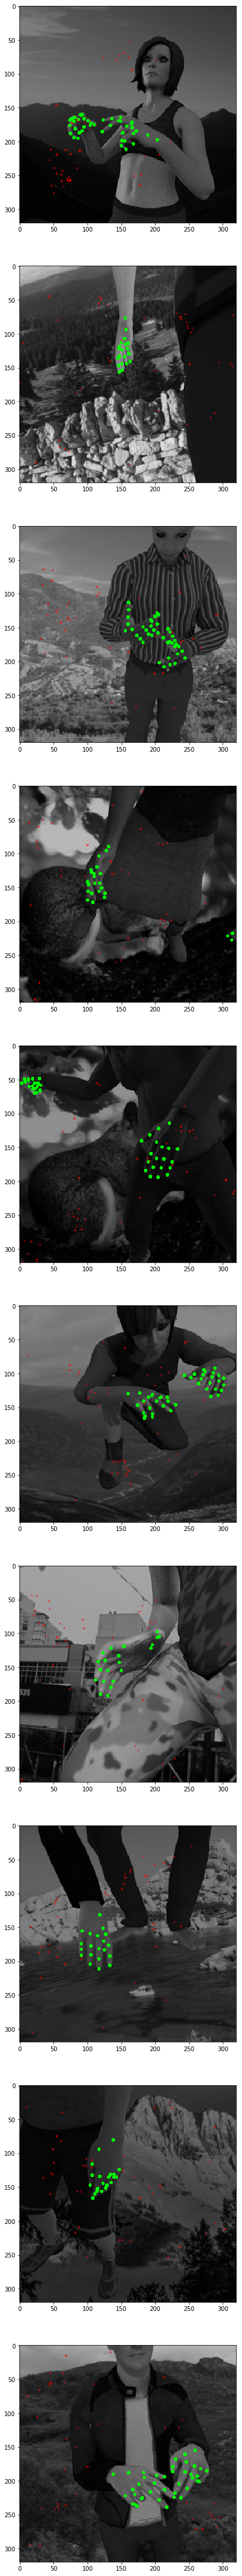

In [18]:
f, subs = plt.subplots(len(images_show), 1, figsize=(15, 8*len(samples_to_check)))
for c, im in enumerate(images_show):
    subs[c].imshow(im)
    #subs[c].set_title(f"Confidence: {np.max(res[c][:,:,:,0])}")

#f = plt.figure(figsize=(20, 20))
#plt.imshow(images_show[0], cmap='gray')